# UT Transformers project: univariate Time-series Deep Encoder on one segment, default vs optimized with Optuna

Enefit Energy consumption/production using one segment. Use the Kaggle predict-energy-behaviour-of-prosumers dataset.

GPU should be enabled to run this notebook. Otherwise it will be very slow.

# 1. Libraries

In this notebook, we can pip install libraries because internet is enabled. To submit a notebook to a competition, the internet has to be disabled. In that case, it is possible to import libraries via a utility script.

In [2]:
!pip install -qq darts

In [3]:
!pip install --quiet torch>=1.10.0 torchvision>=0.11.0 pytorch-lightning==1.9.0 torchmetrics==0.9.3 timm optuna==2.10.1

In [4]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)
import torch
import random

from tqdm.notebook import tqdm
from pytorch_lightning.callbacks import Callback, EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import os
import warnings
from timeit import default_timer as timer

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import polars

import torch
from torch import nn

from darts import TimeSeries
from darts.models import TiDEModel, TFTModel, TransformerModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import fill_missing_values
from darts.metrics import mae

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


# 2. Data preparation

The features to predict the electricity produced and consumed include historical real and forecasted weather data, gas and electricity prices, and data about the prosumers, including their installed photovoltaic capacity. The detailed data descriptions are available on [the competition data page](https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers/data).

Credits for data preparation: https://www.kaggle.com/code/greysky/enefit-darts-study-notes

In [6]:
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target):    
    df_data = (
        df_data
        .join(df_target, on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
    )
    
    df_consume = (
        df_data
        .filter(polars.col("is_consumption").eq(1))
        .select("target", "county", "is_business", "product_type", "datetime")
    )

    df_data = (
        df_data
        .filter(polars.col("is_consumption").eq(0))
        .join(df_consume, on=["county", "is_business", "product_type", "datetime"], how="left")
        .rename({"target": "production", "target_right": "consumption"})
        .with_columns(polars.col("datetime").cast(polars.Date).alias("date"))
        .drop("is_consumption")
    )
    
    df_client = (
        df_client
        .with_columns((polars.col("date") + polars.duration(days=2)).cast(polars.Date))
    )
    
    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns((polars.col("date") + polars.duration(days=1)).cast(polars.Date))
    )

    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(datetime=polars.col("datetime") + polars.duration(days=1))
    )
    
    df_location = (
        df_location
        .with_columns(
            polars.col("latitude").cast(polars.datatypes.Float32),
            polars.col("longitude").cast(polars.datatypes.Float32)
        )
    )
    
    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            polars.col("latitude").cast(polars.datatypes.Float32),
            polars.col("longitude").cast(polars.datatypes.Float32),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
        .with_columns(polars.col("county").fill_nan(12))
        .group_by("county", "datetime").mean()
    )
    
    df_data = (
        df_data
        .join(df_gas, on="date", how="left")
        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")
        .join(df_forecast, on=["county", "datetime"], how="left")
        .with_columns(
            polars.col(polars.Float64).cast(polars.Float32),
        )
        .drop("date")
    )
    
    return df_data

In [7]:
def to_pandas(df):
    df = df.to_pandas()
    df = df.set_index("row_id")
    
    return df

In [8]:
root = "/kaggle/input/predict-energy-behavior-of-prosumers"

data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime']

In [9]:
df_data        = polars.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = polars.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = polars.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = polars.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = polars.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_location    = polars.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)

df_target      = df_data.select(target_cols)
df_data        = df_data.drop("target")

df_data        = df_data.filter(polars.col("datetime").lt(pd.Timestamp("20230528")))
df_client      = df_client.filter(polars.col("date").lt(pd.Timestamp("20230526")))
df_gas         = df_gas.filter(polars.col("forecast_date").lt(pd.Timestamp("20230527")))
df_electricity = df_electricity.filter(polars.col("forecast_date").lt(pd.Timestamp("20230527")))
df_target      = df_target.filter(polars.col("datetime").lt(pd.Timestamp("20230526")))

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_target      = df_target.schema

In [10]:
df_train = feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target)
df_train = to_pandas(df_train)

df_train = df_train[df_train["consumption"].notnull()]
df_train = df_train[df_train["production"].notnull()]

In [11]:
# Remove old data
df_train = df_train[df_train['datetime'] > pd.to_datetime('2022-01-01 00:00:00')]

In [12]:
df_train.shape

(816478, 23)

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 816478 entries, 366178 to 1999534
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   county                             816478 non-null  int64         
 1   is_business                        816478 non-null  int64         
 2   product_type                       816478 non-null  int64         
 3   datetime                           816478 non-null  datetime64[ns]
 4   production                         816478 non-null  float32       
 5   consumption                        816478 non-null  float32       
 6   lowest_price_per_mwh               816478 non-null  float32       
 7   highest_price_per_mwh              816478 non-null  float32       
 8   eic_count                          815281 non-null  float64       
 9   installed_capacity                 815281 non-null  float32       
 10  euros_per_mwh      

# 3. One segment

In [14]:
def to_time_series(df_data, county, is_business, product_type, target = 'production'):
    """Create a Darts time-series for one segment"""
    
    time_col   = "datetime"
    group_cols = ["county", "is_business", "product_type"]
    value_cols = ["consumption","production","lowest_price_per_mwh", "highest_price_per_mwh", "eic_count", "installed_capacity", "euros_per_mwh", 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
    
    df_data = df_data[
        df_data["county"].eq(county) &
        df_data["is_business"].eq(is_business) &
        df_data["product_type"].eq(product_type)
    ]
    
    ts = TimeSeries.from_dataframe(
        df_data,
        time_col=time_col,
        value_cols=value_cols,
        fill_missing_dates=True,
        freq="1h",
    )
        
    return ts

# Production

# 4. Train-val-test split

Currently not using cross-validation as it would be more time-consuming computation-wise. However, it could increase stability.

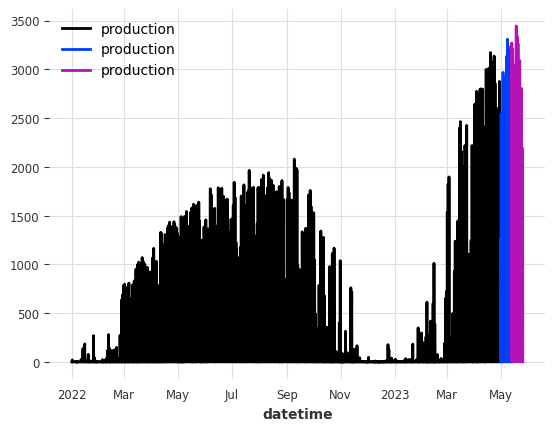

In [15]:
series = to_time_series(df_train, county=0, is_business=0, product_type=1, target='production')

# Fill Missing Values

series = fill_missing_values(series)

# Holidays

series = series.add_holidays("EE") # Estonian holidays

# Train / Test Split

train_series, temp = series.split_before(0.95)
val_series, test_series = temp.split_before(0.50)

train_series['production'].plot()
val_series['production'].plot()
test_series['production'].plot()
plt.show()

In [16]:
len(train_series), len(val_series), len(test_series)

(11626, 306, 307)

In [17]:
len(val_series)-(7*24)

138

# 5. Common settings

In [18]:
# fixed parameters that will be the same for all models
SEED = 42
MAX_N_EPOCHS = 30 # Default in Darts for Vanilla, TiDE and TFT is 100
BATCH_SIZE = 128 # Default in Darts is 32
IN_LEN = 7*24 #  Number of time steps in the past to take as a model input (per chunk)
OUT_LEN = 2*24 # Number of time steps predicted at once (per chunk) by the internal model.
NR_EPOCHS_VAL_PERIOD = 1

In [19]:
# encoders
encoders={
'cyclic': {'future': ['hour', 'dayofyear']},
'datetime_attribute': {'future': ['hour', 'dayofweek']},
'position': {'past': ['relative'], 'future': ['relative']},
'transformer': Scaler(),
}

![Source: Darts documentation](https://unit8co.github.io/darts/_images/covariates-highlevel.png)

In [20]:
target_col = ["production"]
past_covariates = ["consumption","lowest_price_per_mwh", "highest_price_per_mwh", "eic_count", "installed_capacity", "euros_per_mwh"]
future_covariates = ["holidays", "temperature", "dewpoint", "cloudcover_high", "cloudcover_mid", "cloudcover_low", "cloudcover_total", "total_precipitation", "surface_solar_radiation_downwards"]

train_target = train_series[target_col]
train_past_covariates = train_series[past_covariates]
train_future_covariates = train_series[future_covariates]

val_target = val_series[target_col]
val_past_covariates = val_series[past_covariates]
val_future_covariates = val_series[future_covariates]

test_target = test_series[target_col]
test_past_covariates = test_series[past_covariates]
test_future_covariates = test_series[future_covariates]

In [21]:
# We have to leave at least input chunk len to predict the first increment
prediction_len = len(val_target)-(IN_LEN)
prediction_len

138

As metric, we use MAE which is the official metric in the Kaggle competition.

In [22]:
def get_results(truth, preds):
    
    MAE = mae(truth, preds)
    
    print('MAE: ', MAE)
    
    results_dict = {
    "MAE": MAE,
    }
    
    return results_dict

In [23]:
all_results = {}

# 6. Time-series Dense Encoder (TiDE)

Uses multilayer perceptron (MLP)-based encoder-decoders without attention. TiDE is faster than transformers that use attention.

Default hyperparams: (input_chunk_length, output_chunk_length, num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, **kwargs)

https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tide_model.html

https://arxiv.org/pdf/2304.08424.pdf

Below is a snippet from the TiDE paper:

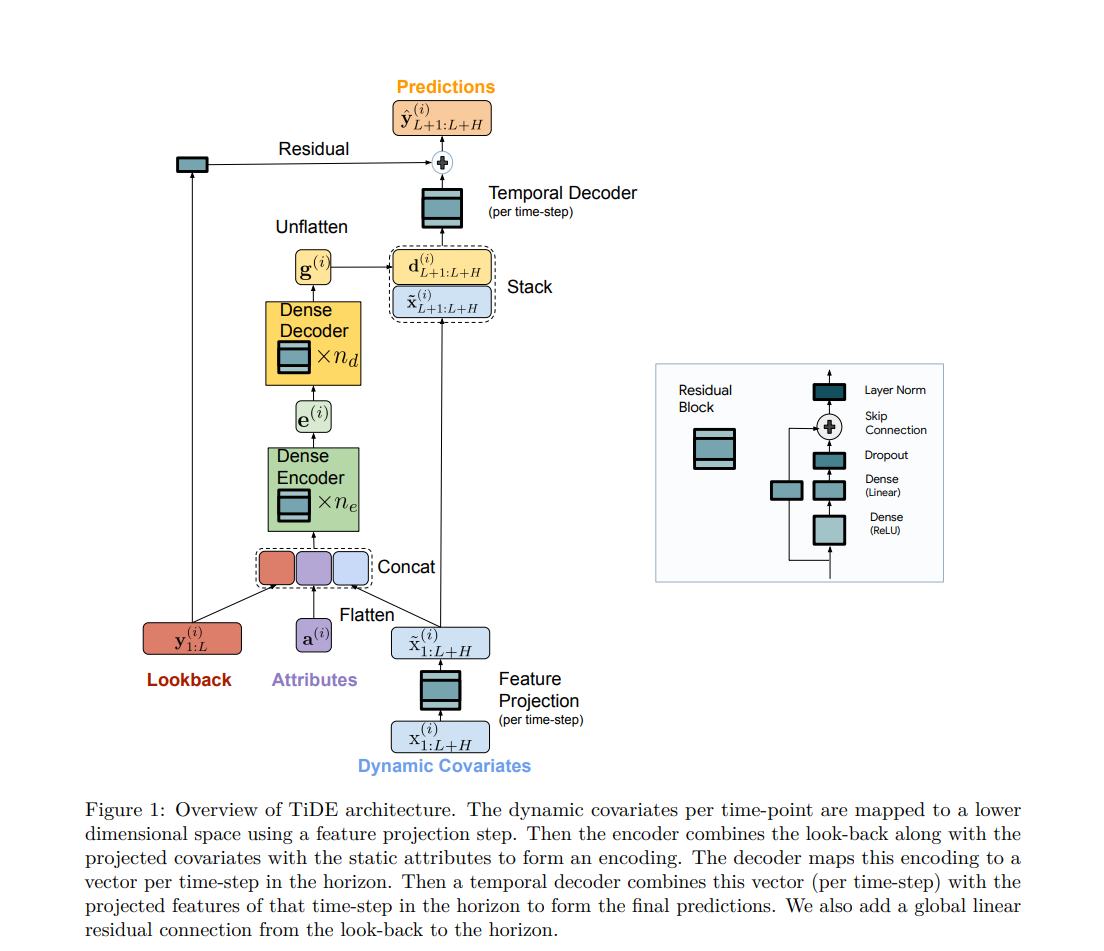

## 6.1 TiDE with default hyperparameters

Default hyperparams: (input_chunk_length, output_chunk_length, num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, **kwargs)

In [24]:
N_EPOCHS=100 # Max number of epochs, we will be using early stopping

In [25]:
# throughout training we'll monitor the validation loss for early stopping
early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
callbacks = [early_stopper]

# detect if a GPU is available
if torch.cuda.is_available():
    pl_trainer_kwargs = {
        "accelerator": "gpu",
        "devices": [0],
        "callbacks": callbacks,
    }
    num_workers = 4
else:
    pl_trainer_kwargs = {"callbacks": callbacks}
    num_workers = 0

In [56]:
model_TiDE = TiDEModel(
    input_chunk_length=IN_LEN,
    output_chunk_length=OUT_LEN,
    add_encoders=encoders,
    loss_fn=nn.L1Loss(),
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    random_state=SEED,
    pl_trainer_kwargs=pl_trainer_kwargs,
    model_name="tide_model",
    save_checkpoints=True,
    force_reset=True
)

start = timer()
model_TiDE.fit(
    series=train_target,
    past_covariates=train_past_covariates,
    future_covariates=train_future_covariates,
    val_series=val_target,
    val_past_covariates=val_past_covariates,
    val_future_covariates=val_future_covariates,
)

end = timer()
fitting_TiDE = end - start
print("Fitting Time:", round(fitting_TiDE, 2), "seconds")

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Fitting Time: 59.99 seconds


In [57]:
model_TiDE_best = TiDEModel.load_from_checkpoint("tide_model")

Predicting: 0it [00:00, ?it/s]

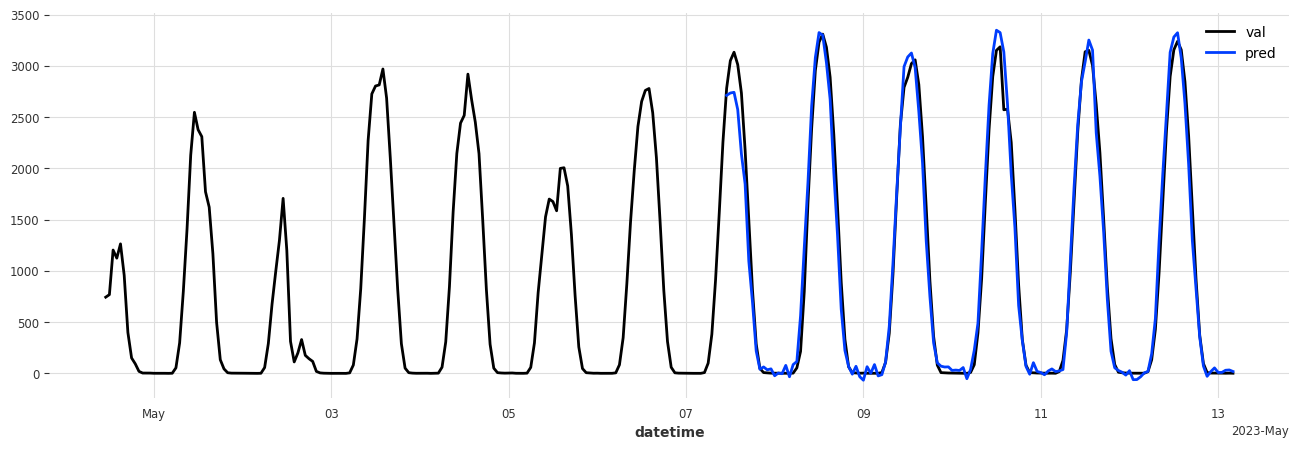

In [58]:
prediction = model_TiDE_best.predict(
    prediction_len, val_target[:-prediction_len],
    past_covariates=val_past_covariates,
    future_covariates=val_future_covariates,
)

plt.figure(figsize=(16, 5))

val_target.plot(label="val")
prediction.plot(label="pred")
plt.show()

In [59]:
all_results['TiDE_default'] = get_results(val_target[IN_LEN:], prediction)

MAE:  117.81118731616476


Predicting: 0it [00:00, ?it/s]

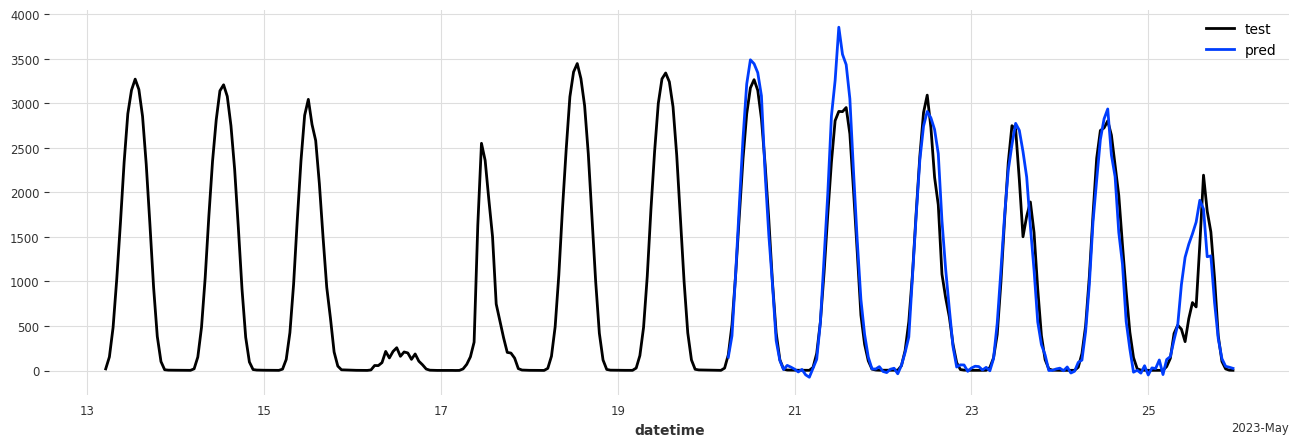

In [60]:
prediction = model_TiDE_best.predict(
    prediction_len, test_target[:-prediction_len],
    past_covariates=test_past_covariates,
    future_covariates=test_future_covariates,
)

plt.figure(figsize=(16, 5))

test_target.plot(label="test")
prediction.plot(label="pred")
plt.show()

In [61]:
all_results['TiDE_default_test'] = get_results(test_target[IN_LEN:], prediction)

MAE:  171.30675332197478


## 6.2 Optimizing TiDE with Optuna

For optimizing, we use the same hyperparameter ranges as presented in the TiDE paper.

In [28]:
def build_fit_tide_model(
    IN_LEN,
    num_encoder_layers,
    num_decoder_layers,
    decoder_output_dim,
    temporal_decoder_hidden,
    use_layer_norm,
    use_reversible_instance_norm,
    dropout,
    lr,
    likelihood=None,
    callbacks=None,
    encoders=encoders,
    batch_size=BATCH_SIZE,
    n_epochs=MAX_N_EPOCHS,
):

    # reproducibility
    torch.manual_seed(SEED)
    
    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "devices": [0],
            "callbacks": callbacks,
            "precision":64
        }
        num_workers = 4
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    
    model_TiDE = TiDEModel(
        input_chunk_length=IN_LEN,
        output_chunk_length=OUT_LEN,
        add_encoders=encoders,
        loss_fn=nn.L1Loss(),
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        decoder_output_dim=decoder_output_dim,
        temporal_decoder_hidden=temporal_decoder_hidden,
        dropout=dropout,
        use_layer_norm=use_layer_norm,
        use_reversible_instance_norm=use_reversible_instance_norm,
        optimizer_kwargs={"lr": lr},
        batch_size=batch_size,
        n_epochs=n_epochs,
        random_state=42,
        model_name="tide_model",
        likelihood=likelihood,
        force_reset=True,
        save_checkpoints=True,
        pl_trainer_kwargs=pl_trainer_kwargs,
    )
    
    model_TiDE.fit(
        series=train_target,
        past_covariates=train_past_covariates,
        future_covariates=train_future_covariates,
        val_series=val_target,
        val_past_covariates=val_past_covariates,
        val_future_covariates=val_future_covariates,
        num_loader_workers=num_workers,
    )

    # reload best model over course of training
    model = model_TiDE.load_from_checkpoint("tide_model")

    return model

In [70]:
def objective(trial):
    from darts.metrics import mae
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # set input_chunk_length, between 5 and 30 days
    #days_in = trial.suggest_int("days_in", 5, 30)
    #IN_LEN = days_in * 24
    IN_LEN = 7*24 # Currently fixed to one week, we could try to optimize it
    prediction_len = len(val_target)-(IN_LEN)


    # Other hyperparameters
    num_encoder_layers = trial.suggest_int("num_encoder_layers", 1, 3)
    num_decoder_layers = trial.suggest_int("num_decoder_layers", 1, 3)
    decoder_output_dim = trial.suggest_categorical("decoder_output_dim", [4, 8, 16, 32])
    temporal_decoder_hidden  = trial.suggest_categorical("temporal_decoder_hidden", [32, 64, 128])
    dropout = trial.suggest_categorical("dropout", [0.0, 0.1, 0.2, 0.3, 0.5])
    use_layer_norm = trial.suggest_categorical("use_layer_norm", [False, True])
    use_reversible_instance_norm = trial.suggest_categorical("use_reversible_instance_norm", [False, True])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)

    # build and train the TCN model with these hyper-parameters:
    model = build_fit_tide_model(
        IN_LEN,
        num_encoder_layers,
        num_decoder_layers,
        decoder_output_dim,
        temporal_decoder_hidden,
        use_layer_norm,
        use_reversible_instance_norm,
        dropout,
        lr,
        likelihood=None,
        callbacks=None,
    )

    # Evaluate how good it is on the validation set
    prediction = model.predict(
        prediction_len, val_target[:-prediction_len], # Use the max possible prediction len which is the length of the val target - input chunch len
        past_covariates=val_past_covariates,
        future_covariates=val_future_covariates,
    )

    mae = mae(val_target[IN_LEN:], prediction)

    return mae if mae != np.nan else float("inf")

In [71]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [72]:
study = optuna.create_study(direction="minimize")

# Time-out at 2 hours
study.optimize(objective, timeout=7200, callbacks=[print_callback])

# The best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

[I 2024-01-14 13:53:58,419] A new study created in memory with name: no-name-c3757ebe-1691-4174-a8ea-05533f60880f


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 13:54:26,617] Trial 0 finished with value: 518.9929285044703 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0052534271294996035}. Best is trial 0 with value: 518.9929285044703.


Current value: 518.9929285044703, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0052534271294996035}
Best value: 518.9929285044703, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0052534271294996035}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 13:55:25,208] Trial 1 finished with value: 89.04334069763037 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}. Best is trial 1 with value: 89.04334069763037.


Current value: 89.04334069763037, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 13:56:04,721] Trial 2 finished with value: 533.5948048064993 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 128, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0032213045775165363}. Best is trial 1 with value: 89.04334069763037.


Current value: 533.5948048064993, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 128, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0032213045775165363}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 13:57:15,552] Trial 3 finished with value: 500.89134704622035 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.00031295673259993013}. Best is trial 1 with value: 89.04334069763037.


Current value: 500.89134704622035, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.00031295673259993013}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 13:58:36,777] Trial 4 finished with value: 529.454173711429 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.0003821860917974691}. Best is trial 1 with value: 89.04334069763037.


Current value: 529.454173711429, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.0003821860917974691}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 13:59:33,539] Trial 5 finished with value: 555.7833315224559 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0011005324638680815}. Best is trial 1 with value: 89.04334069763037.


Current value: 555.7833315224559, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0011005324638680815}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:00:18,763] Trial 6 finished with value: 541.3839149698548 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.00011281703474038845}. Best is trial 1 with value: 89.04334069763037.


Current value: 541.3839149698548, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.00011281703474038845}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:01:11,001] Trial 7 finished with value: 549.2006538696419 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.005135564060510087}. Best is trial 1 with value: 89.04334069763037.


Current value: 549.2006538696419, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.005135564060510087}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:03:12,700] Trial 8 finished with value: 256.11878742524965 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 8.555355738624221e-05}. Best is trial 1 with value: 89.04334069763037.


Current value: 256.11878742524965, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 8.555355738624221e-05}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:04:19,917] Trial 9 finished with value: 707.3879048294754 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 128, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 4.489327663924391e-05}. Best is trial 1 with value: 89.04334069763037.


Current value: 707.3879048294754, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 128, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 4.489327663924391e-05}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:06:22,458] Trial 10 finished with value: 351.113366728057 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.5, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 2.4000728335717496e-05}. Best is trial 1 with value: 89.04334069763037.


Current value: 351.113366728057, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.5, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 2.4000728335717496e-05}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:08:23,318] Trial 11 finished with value: 500.0479594750185 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 1.0406501221095046e-05}. Best is trial 1 with value: 89.04334069763037.


Current value: 500.0479594750185, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 1.0406501221095046e-05}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:09:49,927] Trial 12 finished with value: 243.0025088603319 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.00022505967266535557}. Best is trial 1 with value: 89.04334069763037.


Current value: 243.0025088603319, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.00022505967266535557}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:11:16,166] Trial 13 finished with value: 190.15641938180494 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0005087147147728289}. Best is trial 1 with value: 89.04334069763037.


Current value: 190.15641938180494, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0005087147147728289}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:11:51,966] Trial 14 finished with value: 194.52088540867663 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.001114001833118406}. Best is trial 1 with value: 89.04334069763037.


Current value: 194.52088540867663, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.001114001833118406}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:12:39,889] Trial 15 finished with value: 188.4686972876165 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0009673893732625427}. Best is trial 1 with value: 89.04334069763037.


Current value: 188.4686972876165, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0009673893732625427}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:13:13,363] Trial 16 finished with value: 135.10863010483988 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012795485351684175}. Best is trial 1 with value: 89.04334069763037.


Current value: 135.10863010483988, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012795485351684175}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:14:30,140] Trial 17 finished with value: 153.729041007972 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.009920235787122162}. Best is trial 1 with value: 89.04334069763037.


Current value: 153.729041007972, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.009920235787122162}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:14:54,595] Trial 18 finished with value: 126.36453408005353 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002181105596444221}. Best is trial 1 with value: 89.04334069763037.


Current value: 126.36453408005353, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002181105596444221}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:15:35,457] Trial 19 finished with value: 113.80429126434838 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0025183149946607507}. Best is trial 1 with value: 89.04334069763037.


Current value: 113.80429126434838, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0025183149946607507}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:16:24,567] Trial 20 finished with value: 102.84379911516216 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0001510687989621597}. Best is trial 1 with value: 89.04334069763037.


Current value: 102.84379911516216, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0001510687989621597}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:17:05,392] Trial 21 finished with value: 151.20086569709994 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00014787954286351218}. Best is trial 1 with value: 89.04334069763037.


Current value: 151.20086569709994, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00014787954286351218}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:18:02,111] Trial 22 finished with value: 163.8310836290179 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 6.77753434377852e-05}. Best is trial 1 with value: 89.04334069763037.


Current value: 163.8310836290179, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 6.77753434377852e-05}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:18:42,902] Trial 23 finished with value: 125.99714547700039 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005202402126510291}. Best is trial 1 with value: 89.04334069763037.


Current value: 125.99714547700039, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005202402126510291}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:19:35,320] Trial 24 finished with value: 96.53721155123948 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00019102015415439273}. Best is trial 1 with value: 89.04334069763037.


Current value: 96.53721155123948, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00019102015415439273}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:20:15,666] Trial 25 finished with value: 124.38854320363285 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00020481494958757735}. Best is trial 1 with value: 89.04334069763037.


Current value: 124.38854320363285, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00020481494958757735}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:21:59,539] Trial 26 finished with value: 126.39832312012824 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 3.3614113502396454e-05}. Best is trial 1 with value: 89.04334069763037.


Current value: 126.39832312012824, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 3.3614113502396454e-05}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:22:52,116] Trial 27 finished with value: 98.72162342605166 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00018964956306426263}. Best is trial 1 with value: 89.04334069763037.


Current value: 98.72162342605166, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00018964956306426263}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:23:33,111] Trial 28 finished with value: 102.91132456409176 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006780025153116911}. Best is trial 1 with value: 89.04334069763037.


Current value: 102.91132456409176, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006780025153116911}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:24:32,540] Trial 29 finished with value: 100.97118518577224 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00026519259382310357}. Best is trial 1 with value: 89.04334069763037.


Current value: 100.97118518577224, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00026519259382310357}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:26:33,997] Trial 30 finished with value: 111.92993887231938 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 5.345236521304527e-05}. Best is trial 1 with value: 89.04334069763037.


Current value: 111.92993887231938, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 5.345236521304527e-05}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:27:31,822] Trial 31 finished with value: 102.58739187537813 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00029319920898047866}. Best is trial 1 with value: 89.04334069763037.


Current value: 102.58739187537813, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00029319920898047866}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:28:29,672] Trial 32 finished with value: 109.80865175754434 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00016662147626727466}. Best is trial 1 with value: 89.04334069763037.


Current value: 109.80865175754434, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00016662147626727466}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:29:27,827] Trial 33 finished with value: 151.65976829135062 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00010480730955041898}. Best is trial 1 with value: 89.04334069763037.


Current value: 151.65976829135062, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00010480730955041898}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:30:25,541] Trial 34 finished with value: 100.7739714942087 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00033037153235192257}. Best is trial 1 with value: 89.04334069763037.


Current value: 100.7739714942087, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00033037153235192257}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:31:16,068] Trial 35 finished with value: 566.2224628170178 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.000406858270002548}. Best is trial 1 with value: 89.04334069763037.


Current value: 566.2224628170178, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.000406858270002548}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:32:11,439] Trial 36 finished with value: 121.28140184682947 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005819331444889701}. Best is trial 1 with value: 89.04334069763037.


Current value: 121.28140184682947, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005819331444889701}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:33:41,685] Trial 37 finished with value: 527.9015046682675 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.00034729426433749634}. Best is trial 1 with value: 89.04334069763037.


Current value: 527.9015046682675, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.00034729426433749634}
Best value: 89.04334069763037, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00040413015551613333}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:34:28,678] Trial 38 finished with value: 80.06993960857686 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}. Best is trial 38 with value: 80.06993960857686.


Current value: 80.06993960857686, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:35:03,069] Trial 39 finished with value: 543.0401884113301 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0007921608528073499}. Best is trial 38 with value: 80.06993960857686.


Current value: 543.0401884113301, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0007921608528073499}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:35:28,774] Trial 40 finished with value: 119.64085210625277 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0015688005963687601}. Best is trial 38 with value: 80.06993960857686.


Current value: 119.64085210625277, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0015688005963687601}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:36:23,797] Trial 41 finished with value: 91.47788698739838 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003906095808113029}. Best is trial 38 with value: 80.06993960857686.


Current value: 91.47788698739838, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003906095808113029}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:37:18,316] Trial 42 finished with value: 113.01555795164393 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00020417748208016682}. Best is trial 38 with value: 80.06993960857686.


Current value: 113.01555795164393, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00020417748208016682}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:38:12,723] Trial 43 finished with value: 109.25598363274457 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00010894521261457077}. Best is trial 38 with value: 80.06993960857686.


Current value: 109.25598363274457, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00010894521261457077}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:38:58,346] Trial 44 finished with value: 80.23757755578531 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000801955099647466}. Best is trial 38 with value: 80.06993960857686.


Current value: 80.23757755578531, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000801955099647466}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:39:41,810] Trial 45 finished with value: 518.4560562285194 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0007828183681430658}. Best is trial 38 with value: 80.06993960857686.


Current value: 518.4560562285194, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0007828183681430658}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:40:20,268] Trial 46 finished with value: 230.83381995539193 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0017363758666553188}. Best is trial 38 with value: 80.06993960857686.


Current value: 230.83381995539193, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0017363758666553188}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:41:14,505] Trial 47 finished with value: 111.40739947383258 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.004229571717251524}. Best is trial 38 with value: 80.06993960857686.


Current value: 111.40739947383258, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.004229571717251524}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:41:44,323] Trial 48 finished with value: 111.96454618541838 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009441991127710497}. Best is trial 38 with value: 80.06993960857686.


Current value: 111.96454618541838, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009441991127710497}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:42:26,802] Trial 49 finished with value: 90.38305182590537 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004601879546010689}. Best is trial 38 with value: 80.06993960857686.


Current value: 90.38305182590537, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004601879546010689}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:43:39,024] Trial 50 finished with value: 522.7743983564532 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.0004653488513154638}. Best is trial 38 with value: 80.06993960857686.


Current value: 522.7743983564532, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.0004653488513154638}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:44:08,163] Trial 51 finished with value: 100.63568760178705 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013652752742500257}. Best is trial 38 with value: 80.06993960857686.


Current value: 100.63568760178705, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013652752742500257}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:44:49,078] Trial 52 finished with value: 83.03417733119879 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00061375817019474}. Best is trial 38 with value: 80.06993960857686.


Current value: 83.03417733119879, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00061375817019474}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:45:30,397] Trial 53 finished with value: 83.86840459292614 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005811261819861547}. Best is trial 38 with value: 80.06993960857686.


Current value: 83.86840459292614, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005811261819861547}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:46:24,475] Trial 54 finished with value: 96.75509462763209 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006117356896635252}. Best is trial 38 with value: 80.06993960857686.


Current value: 96.75509462763209, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006117356896635252}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:47:46,251] Trial 55 finished with value: 86.4431730277126 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009221042439419723}. Best is trial 38 with value: 80.06993960857686.


Current value: 86.4431730277126, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009221042439419723}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:48:40,133] Trial 56 finished with value: 222.06644218406765 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0009722344688186705}. Best is trial 38 with value: 80.06993960857686.


Current value: 222.06644218406765, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0009722344688186705}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:49:08,929] Trial 57 finished with value: 93.46320024022641 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0024817790973436643}. Best is trial 38 with value: 80.06993960857686.


Current value: 93.46320024022641, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0024817790973436643}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:49:53,892] Trial 58 finished with value: 80.97204196380952 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008063198639370724}. Best is trial 38 with value: 80.06993960857686.


Current value: 80.97204196380952, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008063198639370724}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:50:35,209] Trial 59 finished with value: 91.72766449319336 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0018793125290406632}. Best is trial 38 with value: 80.06993960857686.


Current value: 91.72766449319336, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0018793125290406632}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:51:19,955] Trial 60 finished with value: 127.65327332160095 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0034010615918676664}. Best is trial 38 with value: 80.06993960857686.


Current value: 127.65327332160095, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0034010615918676664}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:52:05,136] Trial 61 finished with value: 87.73727505776702 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011852208690469714}. Best is trial 38 with value: 80.06993960857686.


Current value: 87.73727505776702, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011852208690469714}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:52:30,515] Trial 62 finished with value: 104.61340891203977 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012060543200693493}. Best is trial 38 with value: 80.06993960857686.


Current value: 104.61340891203977, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012060543200693493}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:53:15,686] Trial 63 finished with value: 91.37865296257469 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007658043127203643}. Best is trial 38 with value: 80.06993960857686.


Current value: 91.37865296257469, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007658043127203643}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:53:41,832] Trial 64 finished with value: 126.64263384060526 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011458093932651037}. Best is trial 38 with value: 80.06993960857686.


Current value: 126.64263384060526, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011458093932651037}
Best value: 80.06993960857686, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007563348111409721}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:54:28,104] Trial 65 finished with value: 74.7846325381238 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006647726600327279}. Best is trial 65 with value: 74.7846325381238.


Current value: 74.7846325381238, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006647726600327279}
Best value: 74.7846325381238, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006647726600327279}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:55:47,799] Trial 66 finished with value: 108.11629985195361 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006749331958530734}. Best is trial 65 with value: 74.7846325381238.


Current value: 108.11629985195361, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006749331958530734}
Best value: 74.7846325381238, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006647726600327279}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:56:42,316] Trial 67 finished with value: 79.52139864303092 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008301477969313117}. Best is trial 65 with value: 74.7846325381238.


Current value: 79.52139864303092, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008301477969313117}
Best value: 74.7846325381238, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006647726600327279}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:58:32,052] Trial 68 finished with value: 220.70263543392994 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0002595230964171772}. Best is trial 65 with value: 74.7846325381238.


Current value: 220.70263543392994, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0002595230964171772}
Best value: 74.7846325381238, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006647726600327279}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 14:59:18,906] Trial 69 finished with value: 89.83789332761657 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005976201457384678}. Best is trial 65 with value: 74.7846325381238.


Current value: 89.83789332761657, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005976201457384678}
Best value: 74.7846325381238, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006647726600327279}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:00:13,241] Trial 70 finished with value: 85.73052746497036 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0014720502646887348}. Best is trial 65 with value: 74.7846325381238.


Current value: 85.73052746497036, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0014720502646887348}
Best value: 74.7846325381238, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006647726600327279}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:00:42,431] Trial 71 finished with value: 107.10814734537999 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0015949776634184485}. Best is trial 65 with value: 74.7846325381238.


Current value: 107.10814734537999, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0015949776634184485}
Best value: 74.7846325381238, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006647726600327279}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:01:37,000] Trial 72 finished with value: 114.98409054236063 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004913671950557819}. Best is trial 65 with value: 74.7846325381238.


Current value: 114.98409054236063, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004913671950557819}
Best value: 74.7846325381238, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006647726600327279}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:02:06,785] Trial 73 finished with value: 96.96300727029953 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007557645736538934}. Best is trial 65 with value: 74.7846325381238.


Current value: 96.96300727029953, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007557645736538934}
Best value: 74.7846325381238, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006647726600327279}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:02:36,108] Trial 74 finished with value: 100.10781522188063 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0014193941896149514}. Best is trial 65 with value: 74.7846325381238.


Current value: 100.10781522188063, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0014193941896149514}
Best value: 74.7846325381238, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006647726600327279}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:03:30,250] Trial 75 finished with value: 63.72515954785244 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}. Best is trial 75 with value: 63.72515954785244.


Current value: 63.72515954785244, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:05:34,375] Trial 76 finished with value: 232.62036685724647 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 1.0719700611165278e-05}. Best is trial 75 with value: 63.72515954785244.


Current value: 232.62036685724647, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 1.0719700611165278e-05}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:07:11,379] Trial 77 finished with value: 519.183557137607 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.000901878240255232}. Best is trial 75 with value: 63.72515954785244.


Current value: 519.183557137607, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.000901878240255232}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:07:41,453] Trial 78 finished with value: 99.70485585775016 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005820919543070027}. Best is trial 75 with value: 63.72515954785244.


Current value: 99.70485585775016, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005820919543070027}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:08:07,065] Trial 79 finished with value: 127.34268288154071 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001990265789665863}. Best is trial 75 with value: 63.72515954785244.


Current value: 127.34268288154071, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001990265789665863}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:08:58,299] Trial 80 finished with value: 90.39015847208964 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003965460470137481}. Best is trial 75 with value: 63.72515954785244.


Current value: 90.39015847208964, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003965460470137481}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:09:53,694] Trial 81 finished with value: 78.90482980849575 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009839659984437997}. Best is trial 75 with value: 63.72515954785244.


Current value: 78.90482980849575, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009839659984437997}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:11:01,436] Trial 82 finished with value: 80.49660725928874 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010070080231450776}. Best is trial 75 with value: 63.72515954785244.


Current value: 80.49660725928874, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010070080231450776}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:11:56,110] Trial 83 finished with value: 66.83104741423058 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010493927157385352}. Best is trial 75 with value: 63.72515954785244.


Current value: 66.83104741423058, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010493927157385352}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:12:37,673] Trial 84 finished with value: 124.39855562135692 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001023265372503115}. Best is trial 75 with value: 63.72515954785244.


Current value: 124.39855562135692, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001023265372503115}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:13:06,737] Trial 85 finished with value: 102.30758517917839 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0023584481599881442}. Best is trial 75 with value: 63.72515954785244.


Current value: 102.30758517917839, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0023584481599881442}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:13:35,903] Trial 86 finished with value: 107.90692328115429 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008205895413913929}. Best is trial 75 with value: 63.72515954785244.


Current value: 107.90692328115429, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008205895413913929}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:14:30,069] Trial 87 finished with value: 188.41409113784343 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0010716269029650964}. Best is trial 75 with value: 63.72515954785244.


Current value: 188.41409113784343, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0010716269029650964}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:15:15,976] Trial 88 finished with value: 472.7667615623377 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0030349243167300055}. Best is trial 75 with value: 63.72515954785244.


Current value: 472.7667615623377, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0030349243167300055}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:15:57,342] Trial 89 finished with value: 120.4123741330346 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012486971290546144}. Best is trial 75 with value: 63.72515954785244.


Current value: 120.4123741330346, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012486971290546144}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:16:22,205] Trial 90 finished with value: 114.62348890345643 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006965554205968903}. Best is trial 75 with value: 63.72515954785244.


Current value: 114.62348890345643, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006965554205968903}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:17:15,358] Trial 91 finished with value: 97.51845881664416 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005233988829120708}. Best is trial 75 with value: 63.72515954785244.


Current value: 97.51845881664416, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005233988829120708}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:17:40,768] Trial 92 finished with value: 213.84135586777978 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008359817464580626}. Best is trial 75 with value: 63.72515954785244.


Current value: 213.84135586777978, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008359817464580626}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:18:10,371] Trial 93 finished with value: 93.1773555935428 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006831785508084352}. Best is trial 75 with value: 63.72515954785244.


Current value: 93.1773555935428, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006831785508084352}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:19:04,539] Trial 94 finished with value: 97.1375664783304 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043432848241467195}. Best is trial 75 with value: 63.72515954785244.


Current value: 97.1375664783304, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043432848241467195}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:19:46,007] Trial 95 finished with value: 89.33008725521644 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 128, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010365421811949944}. Best is trial 75 with value: 63.72515954785244.


Current value: 89.33008725521644, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 128, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010365421811949944}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:20:11,381] Trial 96 finished with value: 151.93663057482053 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00033136779883568445}. Best is trial 75 with value: 63.72515954785244.


Current value: 151.93663057482053, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00033136779883568445}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:20:52,869] Trial 97 finished with value: 94.6923896788085 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012984209003110707}. Best is trial 75 with value: 63.72515954785244.


Current value: 94.6923896788085, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012984209003110707}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:21:30,939] Trial 98 finished with value: 140.86631676580942 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008891466027777785}. Best is trial 75 with value: 63.72515954785244.


Current value: 140.86631676580942, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008891466027777785}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:22:00,291] Trial 99 finished with value: 93.27561506594817 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0016434142820123806}. Best is trial 75 with value: 63.72515954785244.


Current value: 93.27561506594817, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0016434142820123806}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:22:25,743] Trial 100 finished with value: 276.1280704146274 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.009262013377633703}. Best is trial 75 with value: 63.72515954785244.


Current value: 276.1280704146274, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.009262013377633703}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:23:07,688] Trial 101 finished with value: 89.07354509903018 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005568965821732881}. Best is trial 75 with value: 63.72515954785244.


Current value: 89.07354509903018, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005568965821732881}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:24:11,338] Trial 102 finished with value: 96.3566707385053 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006515380723624578}. Best is trial 75 with value: 63.72515954785244.


Current value: 96.3566707385053, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006515380723624578}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:24:53,683] Trial 103 finished with value: 93.7809558932191 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000743339830669858}. Best is trial 75 with value: 63.72515954785244.


Current value: 93.7809558932191, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000743339830669858}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:25:50,522] Trial 104 finished with value: 89.89906331483868 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005155691485714078}. Best is trial 75 with value: 63.72515954785244.


Current value: 89.89906331483868, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005155691485714078}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:26:25,646] Trial 105 finished with value: 106.32628163912077 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011081541182957361}. Best is trial 75 with value: 63.72515954785244.


Current value: 106.32628163912077, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011081541182957361}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:27:10,004] Trial 106 finished with value: 483.04413252136317 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0008580500242916855}. Best is trial 75 with value: 63.72515954785244.


Current value: 483.04413252136317, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0008580500242916855}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:28:03,297] Trial 107 finished with value: 87.13597788849435 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004472055783773512}. Best is trial 75 with value: 63.72515954785244.


Current value: 87.13597788849435, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004472055783773512}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:28:52,144] Trial 108 finished with value: 73.24628882946108 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006386459867183246}. Best is trial 75 with value: 63.72515954785244.


Current value: 73.24628882946108, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006386459867183246}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:29:57,542] Trial 109 finished with value: 87.48624859835554 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00037521899535054745}. Best is trial 75 with value: 63.72515954785244.


Current value: 87.48624859835554, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00037521899535054745}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:30:41,968] Trial 110 finished with value: 122.23816804118484 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00028772602568692397}. Best is trial 75 with value: 63.72515954785244.


Current value: 122.23816804118484, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00028772602568692397}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:31:47,481] Trial 111 finished with value: 80.58635307372698 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006311423103348064}. Best is trial 75 with value: 63.72515954785244.


Current value: 80.58635307372698, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006311423103348064}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:32:13,843] Trial 112 finished with value: 123.59498271902851 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009817436613671162}. Best is trial 75 with value: 63.72515954785244.


Current value: 123.59498271902851, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009817436613671162}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:33:01,855] Trial 113 finished with value: 95.6488727748293 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006843078344591668}. Best is trial 75 with value: 63.72515954785244.


Current value: 95.6488727748293, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006843078344591668}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:33:45,564] Trial 114 finished with value: 87.34162138182548 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013601590731868057}. Best is trial 75 with value: 63.72515954785244.


Current value: 87.34162138182548, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013601590731868057}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:34:36,726] Trial 115 finished with value: 80.86397674945142 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006082089844442803}. Best is trial 75 with value: 63.72515954785244.


Current value: 80.86397674945142, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006082089844442803}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:35:24,216] Trial 116 finished with value: 87.4574040790621 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008353057340309864}. Best is trial 75 with value: 63.72515954785244.


Current value: 87.4574040790621, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008353057340309864}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:36:03,275] Trial 117 finished with value: 177.78299283442846 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007514308530631583}. Best is trial 75 with value: 63.72515954785244.


Current value: 177.78299283442846, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007514308530631583}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:36:46,110] Trial 118 finished with value: 87.19271849310834 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011728091003047065}. Best is trial 75 with value: 63.72515954785244.


Current value: 87.19271849310834, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011728091003047065}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:37:38,289] Trial 119 finished with value: 188.75237957160817 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0009512779910438796}. Best is trial 75 with value: 63.72515954785244.


Current value: 188.75237957160817, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0009512779910438796}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:38:25,188] Trial 120 finished with value: 95.095182297976 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0018696659129855528}. Best is trial 75 with value: 63.72515954785244.


Current value: 95.095182297976, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0018696659129855528}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:39:20,766] Trial 121 finished with value: 92.98145257614411 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006108961557613307}. Best is trial 75 with value: 63.72515954785244.


Current value: 92.98145257614411, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006108961557613307}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:40:06,800] Trial 122 finished with value: 89.73225728368527 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000537836669039608}. Best is trial 75 with value: 63.72515954785244.


Current value: 89.73225728368527, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000537836669039608}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:40:52,790] Trial 123 finished with value: 69.9193397822678 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006613960718085741}. Best is trial 75 with value: 63.72515954785244.


Current value: 69.9193397822678, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006613960718085741}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:41:39,085] Trial 124 finished with value: 78.13791930579625 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007550342878325136}. Best is trial 75 with value: 63.72515954785244.


Current value: 78.13791930579625, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007550342878325136}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:42:41,358] Trial 125 finished with value: 91.79991255481437 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00045524347370434683}. Best is trial 75 with value: 63.72515954785244.


Current value: 91.79991255481437, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00045524347370434683}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:43:06,758] Trial 126 finished with value: 141.2335303597079 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010429184800441699}. Best is trial 75 with value: 63.72515954785244.


Current value: 141.2335303597079, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010429184800441699}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:43:46,988] Trial 127 finished with value: 158.4411550168261 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006646217215741194}. Best is trial 75 with value: 63.72515954785244.


Current value: 158.4411550168261, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006646217215741194}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:45:01,409] Trial 128 finished with value: 570.2130029455927 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0014493830149928586}. Best is trial 75 with value: 63.72515954785244.


Current value: 570.2130029455927, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0014493830149928586}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:45:36,701] Trial 129 finished with value: 133.14554727760475 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007560700461462204}. Best is trial 75 with value: 63.72515954785244.


Current value: 133.14554727760475, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007560700461462204}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:46:42,109] Trial 130 finished with value: 119.67943992780151 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005066363671302236}. Best is trial 75 with value: 63.72515954785244.


Current value: 119.67943992780151, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005066363671302236}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:47:34,739] Trial 131 finished with value: 79.34935340282838 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008689198889243571}. Best is trial 75 with value: 63.72515954785244.


Current value: 79.34935340282838, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008689198889243571}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:48:23,061] Trial 132 finished with value: 100.0549897757935 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012038526339169108}. Best is trial 75 with value: 63.72515954785244.


Current value: 100.0549897757935, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012038526339169108}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:49:23,023] Trial 133 finished with value: 130.34287256568766 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009050380803790548}. Best is trial 75 with value: 63.72515954785244.


Current value: 130.34287256568766, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009050380803790548}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:50:10,223] Trial 134 finished with value: 86.34171396770878 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006206034797948934}. Best is trial 75 with value: 63.72515954785244.


Current value: 86.34171396770878, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006206034797948934}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:51:01,164] Trial 135 finished with value: 71.36865606800313 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009787035039249242}. Best is trial 75 with value: 63.72515954785244.


Current value: 71.36865606800313, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009787035039249242}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:52:17,260] Trial 136 finished with value: 77.37253848048843 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010303445664916662}. Best is trial 75 with value: 63.72515954785244.


Current value: 77.37253848048843, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010303445664916662}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:52:43,367] Trial 137 finished with value: 135.5308558090209 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010618391981263716}. Best is trial 75 with value: 63.72515954785244.


Current value: 135.5308558090209, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010618391981263716}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:53:04,429] Trial 138 finished with value: 129.2286893749781 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013164509032217598}. Best is trial 75 with value: 63.72515954785244.


Current value: 129.2286893749781, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013164509032217598}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 15:54:20,441] Trial 139 finished with value: 93.4079691515849 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0016206413677075215}. Best is trial 75 with value: 63.72515954785244.


Current value: 93.4079691515849, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0016206413677075215}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}
Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}


Best value: 63.72515954785244, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}

# Time-series Dense Encoder (TiDE) with optimized hyperparameters

{'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009482408272884553}

In [73]:
model_TiDE_optim = build_fit_tide_model(
    7*24,
    num_encoder_layers=2,
    num_decoder_layers=3,
    decoder_output_dim=16,
    temporal_decoder_hidden=32,
    use_layer_norm=False,
    use_reversible_instance_norm=False,
    dropout=0.1,
    lr=0.0009482408272884553,
    likelihood=None,
    n_epochs=100
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

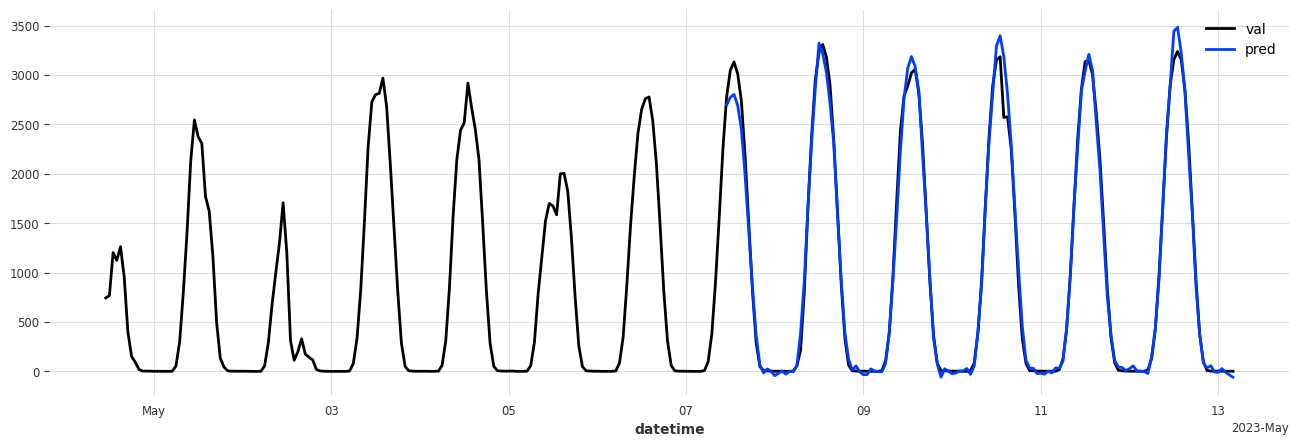

In [74]:
prediction = model_TiDE_optim.predict(
    prediction_len, val_target[:-prediction_len],
    past_covariates=val_past_covariates,
    future_covariates=val_future_covariates,
)

plt.figure(figsize=(16, 5))

val_target.plot(label="val")
prediction.plot(label="pred")
plt.show()

In [75]:
all_results['TiDE_optimized'] = get_results(val_target[IN_LEN:], prediction)

MAE:  63.72515954785244


Predicting: 0it [00:00, ?it/s]

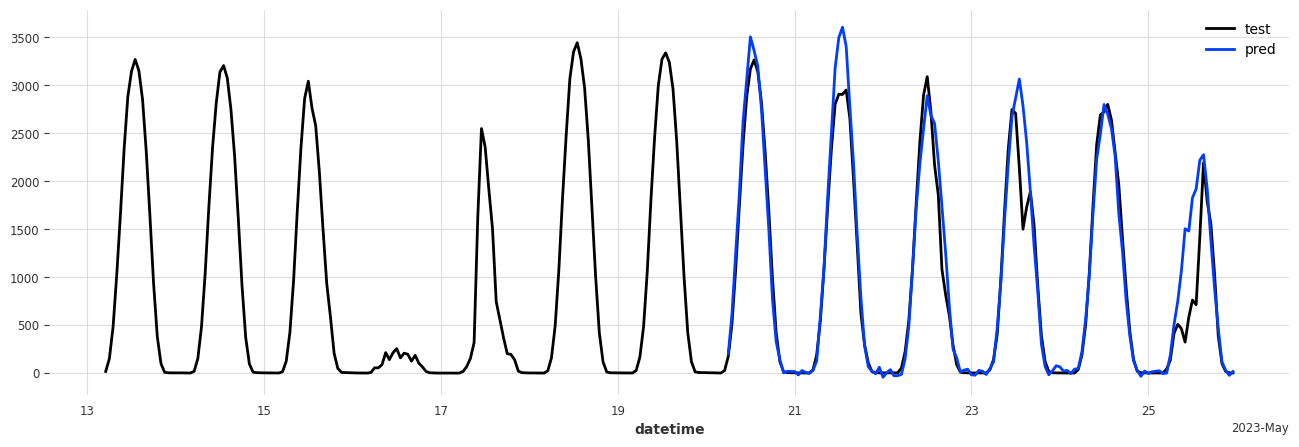

In [76]:
prediction = model_TiDE_optim.predict(
    prediction_len, test_target[:-prediction_len],
    past_covariates=test_past_covariates,
    future_covariates=test_future_covariates,
)

plt.figure(figsize=(16, 5))

test_target.plot(label="test")
prediction.plot(label="pred")
plt.show()

In [77]:
all_results['TiDE_optimized_test'] = get_results(test_target[IN_LEN:], prediction)

MAE:  156.72371168375955


In [78]:
pd.DataFrame(all_results)

,TiDE_default,TiDE_default_test,TiDE_optimized,TiDE_optimized_test
MAE,117.811187,171.306753,63.72516,156.723712


Optimized TiDE is better on validation and on test set. However, the gap between val and test performance is large.

"multivariate models are typically worse than the univariate ones, the reason being the difficulty in estimating the cross-series correlations/relationships" - https://huggingface.co/blog/autoformer

# Consumption

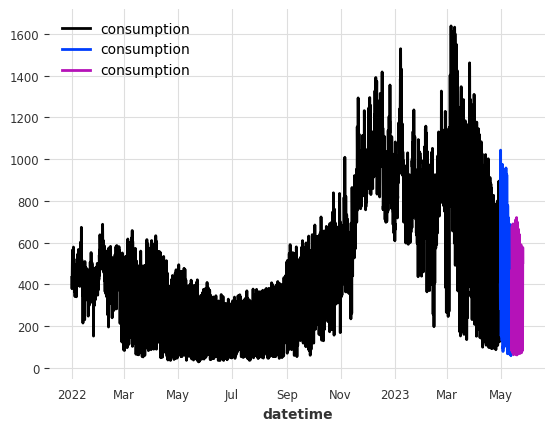

In [36]:
series = to_time_series(df_train, county=0, is_business=0, product_type=1, target='consumption')

# Fill Missing Values

series = fill_missing_values(series)

# Holidays

series = series.add_holidays("EE") # Estonian holidays

# Train / Test Split

train_series, temp = series.split_before(0.95)
val_series, test_series = temp.split_before(0.50)

train_series['consumption'].plot()
val_series['consumption'].plot()
test_series['consumption'].plot()
plt.show()

In [37]:
target_col = ["consumption"]
past_covariates = ["production","lowest_price_per_mwh", "highest_price_per_mwh", "eic_count", "installed_capacity", "euros_per_mwh"]
future_covariates = ["holidays", "temperature", "dewpoint", "cloudcover_high", "cloudcover_mid", "cloudcover_low", "cloudcover_total", "total_precipitation", "surface_solar_radiation_downwards"]

train_target = train_series[target_col]
train_past_covariates = train_series[past_covariates]
train_future_covariates = train_series[future_covariates]

val_target = val_series[target_col]
val_past_covariates = val_series[past_covariates]
val_future_covariates = val_series[future_covariates]

test_target = test_series[target_col]
test_past_covariates = test_series[past_covariates]
test_future_covariates = test_series[future_covariates]

In [38]:
# We have to leave at least input chunk len to predict the first increment
prediction_len = len(val_target)-(IN_LEN)
prediction_len

138

In [82]:
model_TiDE = TiDEModel(
    input_chunk_length=IN_LEN,
    output_chunk_length=OUT_LEN,
    add_encoders=encoders,
    loss_fn=nn.L1Loss(),
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    random_state=SEED,
    pl_trainer_kwargs=pl_trainer_kwargs,
    model_name="tide_model",
    save_checkpoints=True,
    force_reset=True
)

start = timer()
model_TiDE.fit(
    series=train_target,
    past_covariates=train_past_covariates,
    future_covariates=train_future_covariates,
    val_series=val_target,
    val_past_covariates=val_past_covariates,
    val_future_covariates=val_future_covariates,
)

end = timer()
fitting_TiDE = end - start
print("Fitting Time:", round(fitting_TiDE, 2), "seconds")

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Fitting Time: 108.77 seconds


In [83]:
model_TiDE_best = TiDEModel.load_from_checkpoint("tide_model")

Predicting: 0it [00:00, ?it/s]

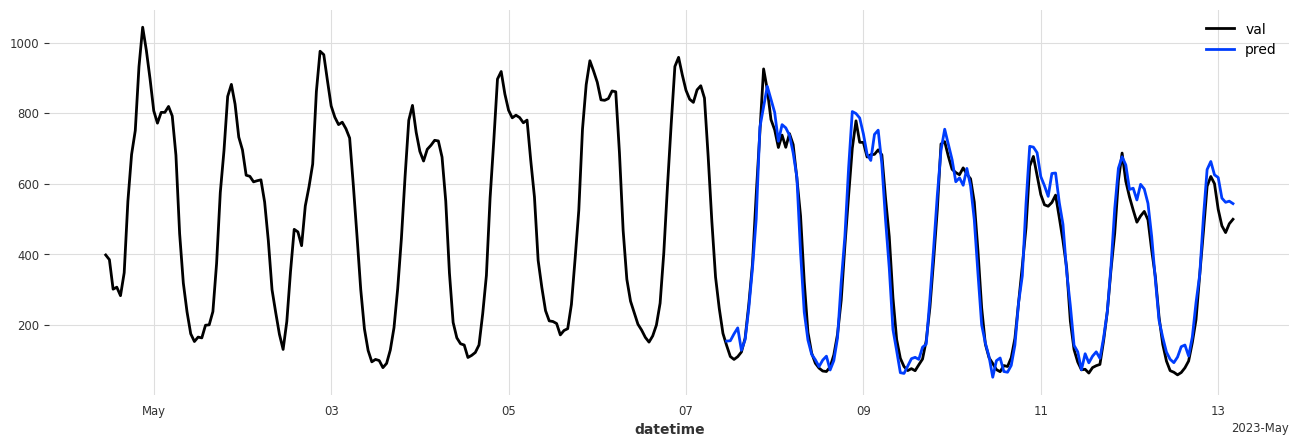

In [84]:
prediction = model_TiDE_best.predict(
    prediction_len, val_target[:-prediction_len],
    past_covariates=val_past_covariates,
    future_covariates=val_future_covariates,
)

plt.figure(figsize=(16, 5))

val_target.plot(label="val")
prediction.plot(label="pred")
plt.show()

In [85]:
all_results['TiDE_default_c'] = get_results(val_target[IN_LEN:], prediction)

MAE:  36.542339155796704


Predicting: 0it [00:00, ?it/s]

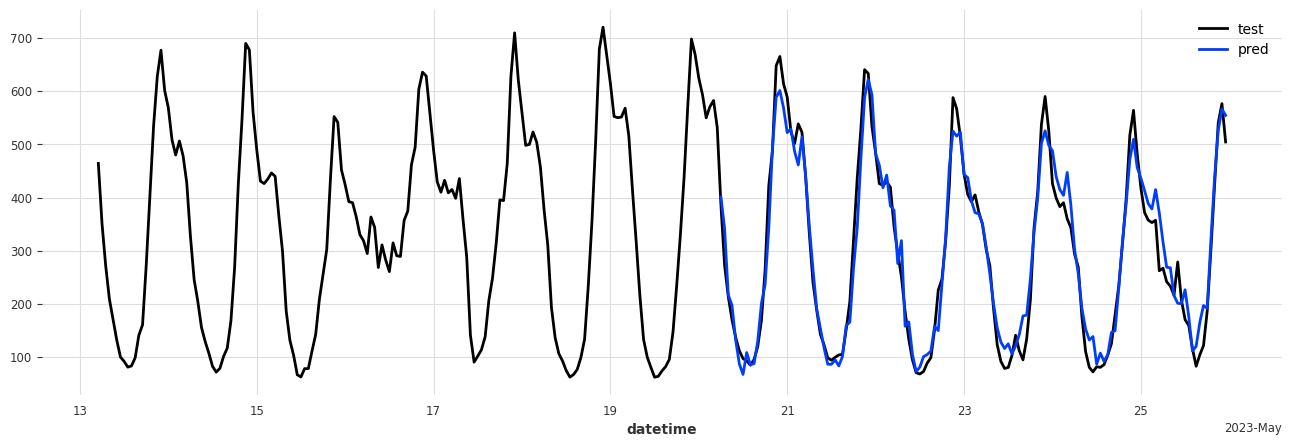

In [86]:
prediction = model_TiDE_best.predict(
    prediction_len, test_target[:-prediction_len],
    past_covariates=test_past_covariates,
    future_covariates=test_future_covariates,
)

plt.figure(figsize=(16, 5))

test_target.plot(label="test")
prediction.plot(label="pred")
plt.show()

In [87]:
all_results['TiDE_default_test_c'] = get_results(test_target[IN_LEN:], prediction)

MAE:  28.618832853809884


In [88]:
all_results

{'TiDE_default': {'MAE': 117.81118731616476},
 'TiDE_default_test': {'MAE': 171.30675332197478},
 'TiDE_optimized': {'MAE': 63.72515954785244},
 'TiDE_optimized_test': {'MAE': 156.72371168375955},
 'TiDE_default_c': {'MAE': 36.542339155796704},
 'TiDE_default_test_c': {'MAE': 28.618832853809884}}

In [89]:
study = optuna.create_study(direction="minimize")

# Time-out at 2 hours
study.optimize(objective, timeout=7200, callbacks=[print_callback])

# The best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

[I 2024-01-14 16:41:03,096] A new study created in memory with name: no-name-a098fbab-1c88-4bd9-ab79-f9860f7f645a


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 16:43:05,533] Trial 0 finished with value: 196.3557969913528 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 1.1044798575151747e-05}. Best is trial 0 with value: 196.3557969913528.


Current value: 196.3557969913528, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 1.1044798575151747e-05}
Best value: 196.3557969913528, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 1.1044798575151747e-05}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 16:45:05,738] Trial 1 finished with value: 95.85849256563449 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 1.573379691740516e-05}. Best is trial 1 with value: 95.85849256563449.


Current value: 95.85849256563449, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 1.573379691740516e-05}
Best value: 95.85849256563449, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 1.573379691740516e-05}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 16:45:43,360] Trial 2 finished with value: 90.61372093506111 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0013660541413810403}. Best is trial 2 with value: 90.61372093506111.


Current value: 90.61372093506111, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0013660541413810403}
Best value: 90.61372093506111, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0013660541413810403}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 16:46:11,907] Trial 3 finished with value: 41.39152961083739 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0034041252188144718}. Best is trial 3 with value: 41.39152961083739.


Current value: 41.39152961083739, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0034041252188144718}
Best value: 41.39152961083739, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0034041252188144718}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 16:46:49,708] Trial 4 finished with value: 117.55667306910009 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.0016052418869372206}. Best is trial 3 with value: 41.39152961083739.


Current value: 117.55667306910009, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.0016052418869372206}
Best value: 41.39152961083739, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0034041252188144718}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 16:47:23,886] Trial 5 finished with value: 38.973516647454225 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0051863684942356865}. Best is trial 5 with value: 38.973516647454225.


Current value: 38.973516647454225, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0051863684942356865}
Best value: 38.973516647454225, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0051863684942356865}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 16:48:33,178] Trial 6 finished with value: 123.34020018645504 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.00029657090106073857}. Best is trial 5 with value: 38.973516647454225.


Current value: 123.34020018645504, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.00029657090106073857}
Best value: 38.973516647454225, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0051863684942356865}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 16:50:44,043] Trial 7 finished with value: 149.12511487813453 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 3.22134903670458e-05}. Best is trial 5 with value: 38.973516647454225.


Current value: 149.12511487813453, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 3.22134903670458e-05}
Best value: 38.973516647454225, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0051863684942356865}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 16:52:48,643] Trial 8 finished with value: 134.75365043889784 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.000120053357943775}. Best is trial 5 with value: 38.973516647454225.


Current value: 134.75365043889784, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.000120053357943775}
Best value: 38.973516647454225, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0051863684942356865}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 16:54:42,146] Trial 9 finished with value: 144.203727336006 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 9.696101663414999e-05}. Best is trial 5 with value: 38.973516647454225.


Current value: 144.203727336006, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 9.696101663414999e-05}
Best value: 38.973516647454225, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0051863684942356865}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 16:55:12,496] Trial 10 finished with value: 111.66028046791989 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.006687716297671653}. Best is trial 5 with value: 38.973516647454225.


Current value: 111.66028046791989, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.006687716297671653}
Best value: 38.973516647454225, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0051863684942356865}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 16:55:49,672] Trial 11 finished with value: 45.52056114746221 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.008742640770288997}. Best is trial 5 with value: 38.973516647454225.


Current value: 45.52056114746221, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.008742640770288997}
Best value: 38.973516647454225, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0051863684942356865}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 16:56:31,059] Trial 12 finished with value: 43.60921674776732 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0020969371283460266}. Best is trial 5 with value: 38.973516647454225.


Current value: 43.60921674776732, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0020969371283460266}
Best value: 38.973516647454225, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0051863684942356865}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 16:57:45,710] Trial 13 finished with value: 42.68493909842918 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0034052265228339132}. Best is trial 5 with value: 38.973516647454225.


Current value: 42.68493909842918, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0034052265228339132}
Best value: 38.973516647454225, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0051863684942356865}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 16:59:24,307] Trial 14 finished with value: 42.14778156293661 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006093222636778437}. Best is trial 5 with value: 38.973516647454225.


Current value: 42.14778156293661, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006093222636778437}
Best value: 38.973516647454225, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0051863684942356865}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:00:22,045] Trial 15 finished with value: 36.00667079574148 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.004280284843563372}. Best is trial 15 with value: 36.00667079574148.


Current value: 36.00667079574148, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.004280284843563372}
Best value: 36.00667079574148, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.004280284843563372}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:00:52,177] Trial 16 finished with value: 44.52951938858979 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008528849184623836}. Best is trial 15 with value: 36.00667079574148.


Current value: 44.52951938858979, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008528849184623836}
Best value: 36.00667079574148, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.004280284843563372}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:01:54,212] Trial 17 finished with value: 36.89212200058665 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003667033779350629}. Best is trial 15 with value: 36.00667079574148.


Current value: 36.89212200058665, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003667033779350629}
Best value: 36.00667079574148, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.004280284843563372}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:03:17,236] Trial 18 finished with value: 210.33967925126967 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.00019715936637304502}. Best is trial 15 with value: 36.00667079574148.


Current value: 210.33967925126967, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.00019715936637304502}
Best value: 36.00667079574148, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.004280284843563372}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:04:31,301] Trial 19 finished with value: 66.24780008573383 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 4.815528204220028e-05}. Best is trial 15 with value: 36.00667079574148.


Current value: 66.24780008573383, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 4.815528204220028e-05}
Best value: 36.00667079574148, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.004280284843563372}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:05:49,525] Trial 20 finished with value: 34.602636825969 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005129040053824831}. Best is trial 20 with value: 34.602636825969.


Current value: 34.602636825969, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005129040053824831}
Best value: 34.602636825969, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005129040053824831}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:06:35,512] Trial 21 finished with value: 39.533345007344586 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005369736183918786}. Best is trial 20 with value: 34.602636825969.


Current value: 39.533345007344586, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005369736183918786}
Best value: 34.602636825969, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005129040053824831}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:07:09,442] Trial 22 finished with value: 50.930158894883014 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00028740371847954115}. Best is trial 20 with value: 34.602636825969.


Current value: 50.930158894883014, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00028740371847954115}
Best value: 34.602636825969, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005129040053824831}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:08:02,322] Trial 23 finished with value: 40.87636714143301 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008100107379400952}. Best is trial 20 with value: 34.602636825969.


Current value: 40.87636714143301, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008100107379400952}
Best value: 34.602636825969, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005129040053824831}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:09:49,526] Trial 24 finished with value: 42.8885913756255 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00013621327154502937}. Best is trial 20 with value: 34.602636825969.


Current value: 42.8885913756255, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00013621327154502937}
Best value: 34.602636825969, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005129040053824831}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:10:43,872] Trial 25 finished with value: 44.7756930069368 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00039921384527455954}. Best is trial 20 with value: 34.602636825969.


Current value: 44.7756930069368, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00039921384527455954}
Best value: 34.602636825969, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005129040053824831}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:12:12,702] Trial 26 finished with value: 188.15445497460678 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 6.742247668908013e-05}. Best is trial 20 with value: 34.602636825969.


Current value: 188.15445497460678, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 6.742247668908013e-05}
Best value: 34.602636825969, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005129040053824831}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:13:53,553] Trial 27 finished with value: 34.162778116796275 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013279963420434462}. Best is trial 27 with value: 34.162778116796275.


Current value: 34.162778116796275, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013279963420434462}
Best value: 34.162778116796275, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013279963420434462}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:15:01,117] Trial 28 finished with value: 38.808909856837225 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0027237693824497884}. Best is trial 27 with value: 34.162778116796275.


Current value: 38.808909856837225, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0027237693824497884}
Best value: 34.162778116796275, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013279963420434462}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:15:39,664] Trial 29 finished with value: 40.891652127923706 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012081080902436002}. Best is trial 27 with value: 34.162778116796275.


Current value: 40.891652127923706, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012081080902436002}
Best value: 34.162778116796275, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013279963420434462}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:16:53,866] Trial 30 finished with value: 44.388415077146746 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.004692561538389929}. Best is trial 27 with value: 34.162778116796275.


Current value: 44.388415077146746, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.004692561538389929}
Best value: 34.162778116796275, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013279963420434462}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:17:39,796] Trial 31 finished with value: 34.92442061778116 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001006708121423137}. Best is trial 27 with value: 34.162778116796275.


Current value: 34.92442061778116, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001006708121423137}
Best value: 34.162778116796275, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013279963420434462}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:18:29,549] Trial 32 finished with value: 41.57832042716368 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009212006832900416}. Best is trial 27 with value: 34.162778116796275.


Current value: 41.57832042716368, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009212006832900416}
Best value: 34.162778116796275, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013279963420434462}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:19:23,842] Trial 33 finished with value: 34.5723299432277 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001936271392030523}. Best is trial 27 with value: 34.162778116796275.


Current value: 34.5723299432277, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001936271392030523}
Best value: 34.162778116796275, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013279963420434462}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:21:11,643] Trial 34 finished with value: 31.543703313378394 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}. Best is trial 34 with value: 31.543703313378394.


Current value: 31.543703313378394, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:21:41,027] Trial 35 finished with value: 42.030103393684996 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0017612096632279772}. Best is trial 34 with value: 31.543703313378394.


Current value: 42.030103393684996, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0017612096632279772}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:22:02,541] Trial 36 finished with value: 119.85600386382878 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0025284887704474816}. Best is trial 34 with value: 31.543703313378394.


Current value: 119.85600386382878, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0025284887704474816}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:24:08,721] Trial 37 finished with value: 303.766914811401 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 1.2947203077478654e-05}. Best is trial 34 with value: 31.543703313378394.


Current value: 303.766914811401, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 1.2947203077478654e-05}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:24:38,477] Trial 38 finished with value: 110.55014564142549 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0014607483372949886}. Best is trial 34 with value: 31.543703313378394.


Current value: 110.55014564142549, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0014607483372949886}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:25:27,564] Trial 39 finished with value: 56.13192105218235 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006152447206131333}. Best is trial 34 with value: 31.543703313378394.


Current value: 56.13192105218235, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006152447206131333}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:26:05,592] Trial 40 finished with value: 119.38306080589862 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.002020449146887643}. Best is trial 34 with value: 31.543703313378394.


Current value: 119.38306080589862, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.002020449146887643}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:26:51,220] Trial 41 finished with value: 45.40852557602142 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011733686990048904}. Best is trial 34 with value: 31.543703313378394.


Current value: 45.40852557602142, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011733686990048904}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:27:52,737] Trial 42 finished with value: 52.14593956540439 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001047352080633859}. Best is trial 34 with value: 31.543703313378394.


Current value: 52.14593956540439, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001047352080633859}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:28:50,314] Trial 43 finished with value: 43.780040047047066 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00047788951628576306}. Best is trial 34 with value: 31.543703313378394.


Current value: 43.780040047047066, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00047788951628576306}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:29:57,369] Trial 44 finished with value: 51.53849010122298 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00021835806131246374}. Best is trial 34 with value: 31.543703313378394.


Current value: 51.53849010122298, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00021835806131246374}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:30:51,194] Trial 45 finished with value: 42.849930038442565 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0029567244972104364}. Best is trial 34 with value: 31.543703313378394.


Current value: 42.849930038442565, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0029567244972104364}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:31:20,641] Trial 46 finished with value: 46.89799478725651 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007220736402056507}. Best is trial 34 with value: 31.543703313378394.


Current value: 46.89799478725651, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007220736402056507}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:31:50,485] Trial 47 finished with value: 94.70899418213256 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.006196411008219665}. Best is trial 34 with value: 31.543703313378394.


Current value: 94.70899418213256, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.006196411008219665}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:32:45,174] Trial 48 finished with value: 35.16071582265961 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0015654926663457394}. Best is trial 34 with value: 31.543703313378394.


Current value: 35.16071582265961, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0015654926663457394}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:33:23,798] Trial 49 finished with value: 159.3717770926839 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0021696192358420024}. Best is trial 34 with value: 31.543703313378394.


Current value: 159.3717770926839, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0021696192358420024}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:33:41,410] Trial 50 finished with value: 81.80913386633206 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.009345343049483179}. Best is trial 34 with value: 31.543703313378394.


Current value: 81.80913386633206, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.009345343049483179}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:34:34,614] Trial 51 finished with value: 38.96964043625395 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001707383251842423}. Best is trial 34 with value: 31.543703313378394.


Current value: 38.96964043625395, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001707383251842423}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:35:32,892] Trial 52 finished with value: 43.59900586246017 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00367981446493474}. Best is trial 34 with value: 31.543703313378394.


Current value: 43.59900586246017, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00367981446493474}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:36:06,352] Trial 53 finished with value: 49.688735452169595 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013741887076825924}. Best is trial 34 with value: 31.543703313378394.


Current value: 49.688735452169595, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013741887076825924}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:36:40,121] Trial 54 finished with value: 56.79306630921365 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010118004086790745}. Best is trial 34 with value: 31.543703313378394.


Current value: 56.79306630921365, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010118004086790745}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:38:44,749] Trial 55 finished with value: 85.05238337578403 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 2.1263092481502765e-05}. Best is trial 34 with value: 31.543703313378394.


Current value: 85.05238337578403, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 2.1263092481502765e-05}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:39:59,874] Trial 56 finished with value: 55.4753180820968 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006949914277297495}. Best is trial 34 with value: 31.543703313378394.


Current value: 55.4753180820968, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006949914277297495}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:40:50,212] Trial 57 finished with value: 41.4886234605762 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001459662286239646}. Best is trial 34 with value: 31.543703313378394.


Current value: 41.4886234605762, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001459662286239646}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:41:50,214] Trial 58 finished with value: 137.94727280714002 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0004780338485470538}. Best is trial 34 with value: 31.543703313378394.


Current value: 137.94727280714002, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0004780338485470538}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:43:19,289] Trial 59 finished with value: 178.27244295791442 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0036880774127393814}. Best is trial 34 with value: 31.543703313378394.


Current value: 178.27244295791442, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0036880774127393814}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:44:00,726] Trial 60 finished with value: 33.96723325392516 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002194908887335422}. Best is trial 34 with value: 31.543703313378394.


Current value: 33.96723325392516, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002194908887335422}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:44:46,068] Trial 61 finished with value: 41.44938193025777 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002084138487070596}. Best is trial 34 with value: 31.543703313378394.


Current value: 41.44938193025777, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002084138487070596}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:45:31,367] Trial 62 finished with value: 42.819761441185236 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002518550223899737}. Best is trial 34 with value: 31.543703313378394.


Current value: 42.819761441185236, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002518550223899737}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:46:08,722] Trial 63 finished with value: 47.50933481340073 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0054482816886266446}. Best is trial 34 with value: 31.543703313378394.


Current value: 47.50933481340073, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0054482816886266446}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:46:50,115] Trial 64 finished with value: 34.52114828906132 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008745579122156253}. Best is trial 34 with value: 31.543703313378394.


Current value: 34.52114828906132, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008745579122156253}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:47:31,634] Trial 65 finished with value: 39.70845286074814 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008582365325953909}. Best is trial 34 with value: 31.543703313378394.


Current value: 39.70845286074814, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008582365325953909}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:48:33,494] Trial 66 finished with value: 43.40157872902293 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00031947885890114}. Best is trial 34 with value: 31.543703313378394.


Current value: 43.40157872902293, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00031947885890114}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:49:10,172] Trial 67 finished with value: 32.810693420361886 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012350003679153405}. Best is trial 34 with value: 31.543703313378394.


Current value: 32.810693420361886, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012350003679153405}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:49:47,883] Trial 68 finished with value: 44.076374729537825 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00123614028127917}. Best is trial 34 with value: 31.543703313378394.


Current value: 44.076374729537825, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00123614028127917}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:50:12,706] Trial 69 finished with value: 43.41740887538399 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.007432555109300307}. Best is trial 34 with value: 31.543703313378394.


Current value: 43.41740887538399, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.007432555109300307}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:51:02,460] Trial 70 finished with value: 45.18818410449198 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0029247220900684716}. Best is trial 34 with value: 31.543703313378394.


Current value: 45.18818410449198, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0029247220900684716}
Best value: 31.543703313378394, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022243648946470482}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:51:45,012] Trial 71 finished with value: 30.93715445198644 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}. Best is trial 71 with value: 30.93715445198644.


Current value: 30.93715445198644, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:52:18,752] Trial 72 finished with value: 36.95065235343286 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0018106367787602844}. Best is trial 71 with value: 30.93715445198644.


Current value: 36.95065235343286, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0018106367787602844}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:53:00,117] Trial 73 finished with value: 31.827813539633244 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005538507780090939}. Best is trial 71 with value: 30.93715445198644.


Current value: 31.827813539633244, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005538507780090939}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:53:36,965] Trial 74 finished with value: 40.89871673146261 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007853859030244975}. Best is trial 71 with value: 30.93715445198644.


Current value: 40.89871673146261, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007853859030244975}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:54:17,601] Trial 75 finished with value: 31.62892195598122 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005857901929583434}. Best is trial 71 with value: 30.93715445198644.


Current value: 31.62892195598122, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005857901929583434}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:54:38,428] Trial 76 finished with value: 116.7937336643653 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0006158429255293778}. Best is trial 71 with value: 30.93715445198644.


Current value: 116.7937336643653, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0006158429255293778}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:55:19,523] Trial 77 finished with value: 133.33590188504016 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0004176797994463281}. Best is trial 71 with value: 30.93715445198644.


Current value: 133.33590188504016, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0004176797994463281}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:56:01,367] Trial 78 finished with value: 38.159328959263306 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00026760570569573825}. Best is trial 71 with value: 30.93715445198644.


Current value: 38.159328959263306, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00026760570569573825}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:56:42,673] Trial 79 finished with value: 34.18212818982843 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011112890542209965}. Best is trial 71 with value: 30.93715445198644.


Current value: 34.18212818982843, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011112890542209965}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:57:20,198] Trial 80 finished with value: 32.74093628589432 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011855807092441743}. Best is trial 71 with value: 30.93715445198644.


Current value: 32.74093628589432, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011855807092441743}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:57:53,379] Trial 81 finished with value: 32.957904174542385 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011503321639574255}. Best is trial 71 with value: 30.93715445198644.


Current value: 32.957904174542385, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011503321639574255}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:58:30,691] Trial 82 finished with value: 36.01851152900649 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012456472090316337}. Best is trial 71 with value: 30.93715445198644.


Current value: 36.01851152900649, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012456472090316337}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:59:12,656] Trial 83 finished with value: 31.56186637068134 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005906048691503041}. Best is trial 71 with value: 30.93715445198644.


Current value: 31.56186637068134, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005906048691503041}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 17:59:54,380] Trial 84 finished with value: 34.449084529610616 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00058708581957234}. Best is trial 71 with value: 30.93715445198644.


Current value: 34.449084529610616, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00058708581957234}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:00:48,685] Trial 85 finished with value: 38.59390690879149 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00039908265011208443}. Best is trial 71 with value: 30.93715445198644.


Current value: 38.59390690879149, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00039908265011208443}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:01:26,573] Trial 86 finished with value: 34.96458189054106 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007013711611047322}. Best is trial 71 with value: 30.93715445198644.


Current value: 34.96458189054106, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007013711611047322}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:01:59,970] Trial 87 finished with value: 40.92927915765465 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002311716111942684}. Best is trial 71 with value: 30.93715445198644.


Current value: 40.92927915765465, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002311716111942684}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:02:46,114] Trial 88 finished with value: 34.39682822430493 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009740112894723057}. Best is trial 71 with value: 30.93715445198644.


Current value: 34.39682822430493, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009740112894723057}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:04:02,001] Trial 89 finished with value: 119.2793503796191 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.000522903406054672}. Best is trial 71 with value: 30.93715445198644.


Current value: 119.2793503796191, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.000522903406054672}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:04:59,419] Trial 90 finished with value: 39.86125064919486 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032242094703656963}. Best is trial 71 with value: 30.93715445198644.


Current value: 39.86125064919486, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032242094703656963}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:05:36,856] Trial 91 finished with value: 38.56466935706657 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0015385617632283353}. Best is trial 71 with value: 30.93715445198644.


Current value: 38.56466935706657, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0015385617632283353}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:06:14,101] Trial 92 finished with value: 35.62890729591951 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007494425887537013}. Best is trial 71 with value: 30.93715445198644.


Current value: 35.62890729591951, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007494425887537013}
Best value: 30.93715445198644, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010178285883292006}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:06:55,097] Trial 93 finished with value: 30.12111804479334 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001211340610712546}. Best is trial 93 with value: 30.12111804479334.


Current value: 30.12111804479334, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001211340610712546}
Best value: 30.12111804479334, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001211340610712546}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:07:36,716] Trial 94 finished with value: 33.13195983264418 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001122413406329516}. Best is trial 93 with value: 30.12111804479334.


Current value: 33.13195983264418, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001122413406329516}
Best value: 30.12111804479334, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001211340610712546}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:08:13,963] Trial 95 finished with value: 34.48524493556084 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009535098261889615}. Best is trial 93 with value: 30.12111804479334.


Current value: 34.48524493556084, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009535098261889615}
Best value: 30.12111804479334, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001211340610712546}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:08:51,177] Trial 96 finished with value: 38.39054855357611 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006581007112226915}. Best is trial 93 with value: 30.12111804479334.


Current value: 38.39054855357611, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006581007112226915}
Best value: 30.12111804479334, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001211340610712546}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:09:32,282] Trial 97 finished with value: 31.660867496475344 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004542972856584513}. Best is trial 93 with value: 30.12111804479334.


Current value: 31.660867496475344, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004542972856584513}
Best value: 30.12111804479334, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001211340610712546}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:10:13,619] Trial 98 finished with value: 44.00635506792265 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0002261252212727128}. Best is trial 93 with value: 30.12111804479334.


Current value: 44.00635506792265, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0002261252212727128}
Best value: 30.12111804479334, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001211340610712546}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:11:11,436] Trial 99 finished with value: 37.42416623975759 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00044478843782500346}. Best is trial 93 with value: 30.12111804479334.


Current value: 37.42416623975759, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00044478843782500346}
Best value: 30.12111804479334, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001211340610712546}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:12:28,403] Trial 100 finished with value: 31.093890437613652 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00034407384775641067}. Best is trial 93 with value: 30.12111804479334.


Current value: 31.093890437613652, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00034407384775641067}
Best value: 30.12111804479334, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001211340610712546}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:13:37,944] Trial 101 finished with value: 40.09997601864179 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0001738000022110305}. Best is trial 93 with value: 30.12111804479334.


Current value: 40.09997601864179, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0001738000022110305}
Best value: 30.12111804479334, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001211340610712546}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:14:31,231] Trial 102 finished with value: 52.56195424375982 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005526308573577873}. Best is trial 93 with value: 30.12111804479334.


Current value: 52.56195424375982, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005526308573577873}
Best value: 30.12111804479334, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001211340610712546}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:16:41,719] Trial 105 finished with value: 37.57891376470952 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0002637291599091143}. Best is trial 93 with value: 30.12111804479334.


Current value: 37.57891376470952, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0002637291599091143}
Best value: 30.12111804479334, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001211340610712546}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:17:21,984] Trial 106 finished with value: 28.993125418219535 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}. Best is trial 106 with value: 28.993125418219535.


Current value: 28.993125418219535, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:18:01,926] Trial 107 finished with value: 29.799263148492383 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004948278996748289}. Best is trial 106 with value: 28.993125418219535.


Current value: 29.799263148492383, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004948278996748289}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:19:44,078] Trial 109 finished with value: 46.814131495756556 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008104482197092028}. Best is trial 106 with value: 28.993125418219535.


Current value: 46.814131495756556, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008104482197092028}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:20:45,024] Trial 110 finished with value: 39.949987989138606 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004693164132472892}. Best is trial 106 with value: 28.993125418219535.


Current value: 39.949987989138606, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004693164132472892}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:21:27,168] Trial 111 finished with value: 33.260208685465116 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007214649982052961}. Best is trial 106 with value: 28.993125418219535.


Current value: 33.260208685465116, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007214649982052961}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:22:08,081] Trial 112 finished with value: 34.52223774776166 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005792632559763945}. Best is trial 106 with value: 28.993125418219535.


Current value: 34.52223774776166, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005792632559763945}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:23:18,239] Trial 114 finished with value: 32.31544499753044 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008705321373667548}. Best is trial 106 with value: 28.993125418219535.


Current value: 32.31544499753044, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008705321373667548}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:23:55,501] Trial 115 finished with value: 38.92697995746212 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008600778064012103}. Best is trial 106 with value: 28.993125418219535.


Current value: 38.92697995746212, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008600778064012103}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:24:36,863] Trial 116 finished with value: 32.977468854500145 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006378415919831811}. Best is trial 106 with value: 28.993125418219535.


Current value: 32.977468854500145, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006378415919831811}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:25:18,225] Trial 117 finished with value: 35.435938316821066 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003525089687751547}. Best is trial 106 with value: 28.993125418219535.


Current value: 35.435938316821066, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003525089687751547}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:26:03,451] Trial 118 finished with value: 36.75472185739798 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004562052376953711}. Best is trial 106 with value: 28.993125418219535.


Current value: 36.75472185739798, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004562052376953711}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:27:04,467] Trial 119 finished with value: 35.7730249376179 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00029623523662007824}. Best is trial 106 with value: 28.993125418219535.


Current value: 35.7730249376179, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00029623523662007824}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:27:41,759] Trial 120 finished with value: 37.95767667096722 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010233677279299256}. Best is trial 106 with value: 28.993125418219535.


Current value: 37.95767667096722, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010233677279299256}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:28:18,899] Trial 121 finished with value: 37.49713825925123 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0018182959009505127}. Best is trial 106 with value: 28.993125418219535.


Current value: 37.49713825925123, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0018182959009505127}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:28:56,129] Trial 122 finished with value: 35.30810641110735 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008891258410688692}. Best is trial 106 with value: 28.993125418219535.


Current value: 35.30810641110735, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008891258410688692}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:29:36,882] Trial 123 finished with value: 30.348352647581414 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006579912833749428}. Best is trial 106 with value: 28.993125418219535.


Current value: 30.348352647581414, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006579912833749428}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:30:17,643] Trial 124 finished with value: 32.25714853064586 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005450728211201881}. Best is trial 106 with value: 28.993125418219535.


Current value: 32.25714853064586, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005450728211201881}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:30:58,968] Trial 125 finished with value: 29.879136240351016 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000535905133603659}. Best is trial 106 with value: 28.993125418219535.


Current value: 29.879136240351016, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000535905133603659}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:31:39,732] Trial 126 finished with value: 33.12193668889401 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000533610973861417}. Best is trial 106 with value: 28.993125418219535.


Current value: 33.12193668889401, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000533610973861417}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

[I 2024-01-14 18:32:57,935] Trial 128 finished with value: 132.43928127248887 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.0004195394655746955}. Best is trial 106 with value: 28.993125418219535.


Current value: 132.43928127248887, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.0004195394655746955}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:33:27,003] Trial 129 finished with value: 39.77551995041436 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006462445284977171}. Best is trial 106 with value: 28.993125418219535.


Current value: 39.77551995041436, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006462445284977171}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:34:07,829] Trial 130 finished with value: 32.19908465444465 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005700412186284841}. Best is trial 106 with value: 28.993125418219535.


Current value: 32.19908465444465, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005700412186284841}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:34:48,212] Trial 131 finished with value: 33.884196214935294 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005667962606102459}. Best is trial 106 with value: 28.993125418219535.


Current value: 33.884196214935294, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005667962606102459}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:35:28,726] Trial 132 finished with value: 30.247436510315424 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007469393803044248}. Best is trial 106 with value: 28.993125418219535.


Current value: 30.247436510315424, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007469393803044248}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:36:01,035] Trial 133 finished with value: 35.415790993574454 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007561814279854741}. Best is trial 106 with value: 28.993125418219535.


Current value: 35.415790993574454, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007561814279854741}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:37:21,988] Trial 135 finished with value: 33.080697433151926 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004666557145907932}. Best is trial 106 with value: 28.993125418219535.


Current value: 33.080697433151926, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004666557145907932}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:38:13,226] Trial 136 finished with value: 35.12597831598892 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004201599032009966}. Best is trial 106 with value: 28.993125418219535.


Current value: 35.12597831598892, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004201599032009966}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:38:59,993] Trial 137 finished with value: 41.06409221679699 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0002365352428102168}. Best is trial 106 with value: 28.993125418219535.


Current value: 41.06409221679699, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0002365352428102168}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:39:37,148] Trial 138 finished with value: 39.970353340333396 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007622181989021143}. Best is trial 106 with value: 28.993125418219535.


Current value: 39.970353340333396, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007622181989021143}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-14 18:41:23,189] Trial 139 finished with value: 35.39132052476667 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00018000794493500157}. Best is trial 106 with value: 28.993125418219535.


Current value: 35.39132052476667, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00018000794493500157}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}
Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}


# Time-series Dense Encoder (TiDE) with optimized hyperparameters

Best value: 28.993125418219535, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000855336881323519}

In [39]:
model_TiDE_optim = build_fit_tide_model(
    7*24,
    num_encoder_layers=1,
    num_decoder_layers=2,
    decoder_output_dim=4,
    temporal_decoder_hidden=64,
    use_layer_norm=False,
    use_reversible_instance_norm=False,
    dropout=0.0,
    lr=0.000855336881323519,
    likelihood=None,
    n_epochs=100
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

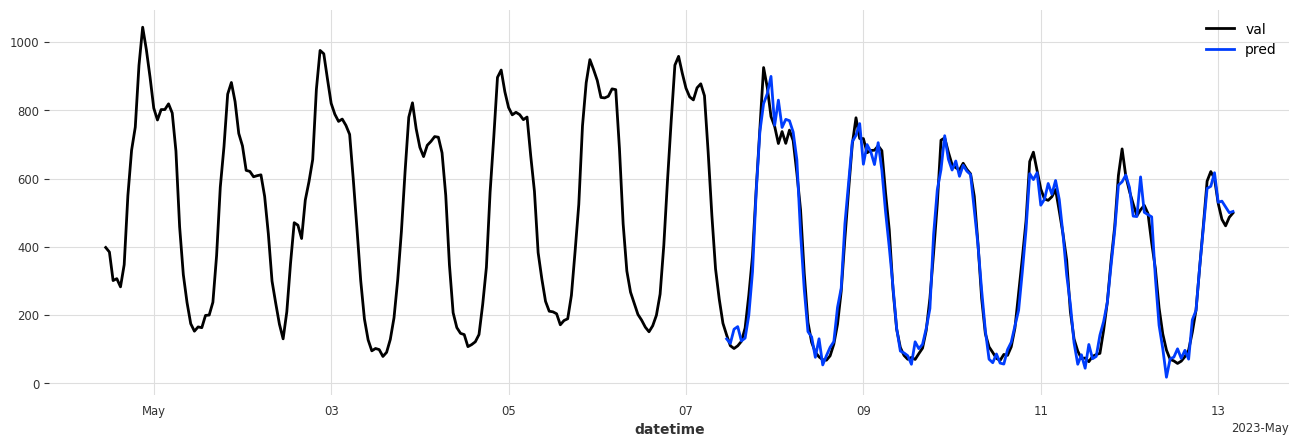

In [40]:
prediction = model_TiDE_optim.predict(
    prediction_len, val_target[:-prediction_len],
    past_covariates=val_past_covariates,
    future_covariates=val_future_covariates,
)

plt.figure(figsize=(16, 5))

val_target.plot(label="val")
prediction.plot(label="pred")
plt.show()

In [41]:
all_results['TiDE_optimized'] = get_results(val_target[IN_LEN:], prediction)

MAE:  28.993125418219535


Predicting: 0it [00:00, ?it/s]

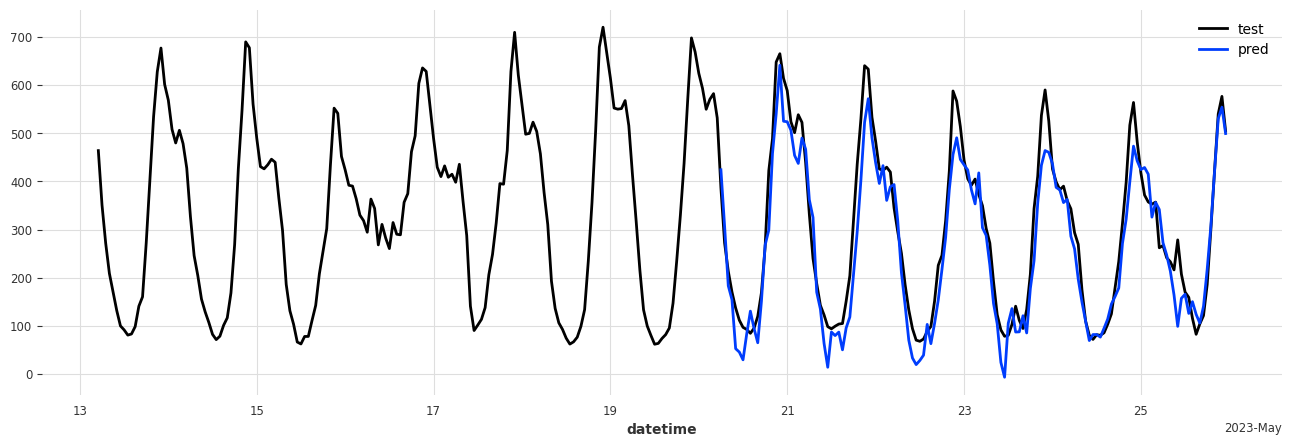

In [42]:
prediction = model_TiDE_optim.predict(
    prediction_len, test_target[:-prediction_len],
    past_covariates=test_past_covariates,
    future_covariates=test_future_covariates,
)

plt.figure(figsize=(16, 5))

test_target.plot(label="test")
prediction.plot(label="pred")
plt.show()

In [43]:
all_results['TiDE_optimized_test'] = get_results(test_target[IN_LEN:], prediction)

MAE:  43.86137110971339


In [44]:
pd.DataFrame(all_results)

,TiDE_optimized,TiDE_optimized_test
MAE,28.993125,43.861371
